In [101]:
import numpy as np
import cv2 
from glob import glob
import matplotlib.pyplot as plt
from keras.applications import ResNet50
from tensorflow import keras
from keras.models import Model
import time
from keras_preprocessing.sequence import pad_sequences
from math import log

In [107]:
img_feature_vectors = np.load('img_feature_vectors.npy', allow_pickle='TRUE').item()
captions_dict_encoded = np.load('captions_dict_encoded.npy', allow_pickle='TRUE').item()
vocab = np.load('vocab.npy', allow_pickle='TRUE').item()

In [108]:
model = keras.models.load_model('models/image_caption_gen_v6.h5')
max_len = 40
vocab_inv = {v: k for k, v in vocab.items()}
images_path = 'Flickr_Data/Images/'
images = glob(images_path+'*.jpg')

resnet_model = ResNet50(include_top=True)
resnet_model = Model(inputs=resnet_model.input, outputs=resnet_model.layers[-2].output)

In [109]:
def generate_caption(img_feature_vector):
    caption = [1]
    next_word = None
    
    while next_word != vocab['eos'] and len(caption) != 40:
        output = model.predict([img_feature_vector, pad(caption)])
        next_word = np.argsort(output)[0][-1]
        caption.append(next_word)
        
    return caption

In [110]:
def generate_img_feature_vector(filepath):
    img = cv2.imread(filepath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = img.reshape(1, 224, 224, 3)
    
    feature_vector = resnet_model.predict(img, verbose=1).reshape(1, 2048)
    
    return feature_vector

In [111]:
def decode_caption(encoded_caption):
    decoded_caption = []
    for word in encoded_caption:
        if word == 0:
            continue
        decoded_caption.append(vocab_inv[word])
    return " ".join(decoded_caption)

In [112]:
def image_caption_generator(filepath, model):
    if type(filepath) == int:
        filepath = images[filepath]
    return decode_caption(generate_caption(generate_img_feature_vector(filepath)))

In [113]:
def show_image(filepath):
    if type(filepath) == int:
        filepath = images[filepath]
    plt.figure()
    img = cv2.imread(filepath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)

In [114]:
start_time = time.time()
print(image_caption_generator(8008, model))
time.time()-start_time

1/1 [==============================] - 0s 28ms/step
sos a man is climbing a rock face . eos


2.0511691570281982

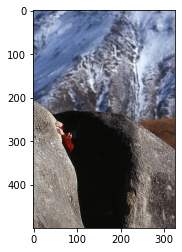

In [116]:
show_image(8008)

Beam search

In [122]:
img_feature_vector = generate_img_feature_vector(images[8008])

1/1 [==============================] - 0s 96ms/step


In [123]:
def pad(alist):
    return np.array([pad_sequences([alist], maxlen=40, truncating='post')[0]])

In [124]:
k=10
candidates = []
current_nodes = [([1], 1)]
current_nodes_copy = current_nodes[:]

while current_nodes != []:
    current_nodes = []
    for x, y in current_nodes_copy:
#         print(current_nodes_copy)
#         print()
        output = model.predict([img_feature_vector, pad(x)], verbose=0)
        next_words = np.argsort(output)[0][-k:]
        for item in next_words:
            new_prob = log(output[0][item])+y
            if item == vocab['eos'] or len(x)==40:
                candidates.append((x+[item],new_prob))
            else:
                current_nodes.append((x+[item],new_prob))
#             print(x)
#             print()
#             print((x+[item],new_prob))
#             print()
    current_nodes_copy = sorted(current_nodes, key=lambda tup:tup[1])[-3:]

In [125]:
a = sorted(candidates, key=lambda tup:tup[1])[-10:]

In [126]:
# smaller captions will have a higher combined probability

In [127]:
for item in a:
    print(decode_caption(item[0]), item[1])

sos a man in a red shirt is climbing a rock face in the water eos -15.81680657423655
sos a man in a red shirt is climbing a rock face in the ocean eos -14.959979308987236
sos a man in a red shirt is standing on a rock face at the ocean . eos -14.688917222552307
sos a man in a red shirt is climbing a rock face in the water . eos -12.609733616640645
sos a man in a red shirt is climbing a rock face in the ocean . eos -12.219758028676399
sos a man in a red shirt is standing on a rock face . eos -12.124199702518073
sos a man in a red shirt is climbing a rock face eos -11.283156011904648
sos a man in a red shirt is climbing a rock face . eos -9.868803534270077
sos a man in a red shirt is climbing a rock . eos -9.667594775010421
sos a man is climbing a rock face . eos -7.0516386021946955
